### Make necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

%matplotlib inline
plt.style.use('ggplot')

#from ltests import model

### Import our combined csv into a DataFrame

In [2]:
raw = pd.read_csv('../../data/master.csv', low_memory=False, dtype={'id': object})

### We would like to select only those entries that have a sale price greater than 0

In [3]:
raw = raw[raw.SalePrice > 0]

### Now we select the sales with the proper PropertyType codes
The following is interest to us:
 - 11: Household, single family units

These are not because they don't help us answer our questions about homeownership

 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums
  
*These codes can be found in the Lookup.zip file located at*

https://info.kingcounty.gov/assessor/DataDownload/default.aspx 

In [4]:
proptypes = [11]

df = raw[raw.PropertyType.isin(proptypes)]

In [5]:
raw[raw.PropertyType == 14].SalePrice.describe()

count    2.217000e+03
mean     4.537666e+05
std      2.872387e+05
min      5.100000e+04
25%      2.800000e+05
50%      3.800000e+05
75%      5.500000e+05
max      4.500000e+06
Name: SalePrice, dtype: float64

### Generate our first simple model of Sale Price vs Sqft of Living Space

In [6]:
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving'
fsm = ols(formula=formula, data=fsm_df).fit()

Let's see that big table

In [7]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.187e+04
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:50:49   Log-Likelihood:            -2.7203e+05
No. Observations:               18807   AIC:                         5.441e+05
Df Residuals:                   18805   BIC:                         5.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.591e+04   8189.002     -1.942      0.052    -3.2e+04     144.477
SqFtTotLiving   378.6638      3.476    108.935      0.000     371.850     385.477
==============================================================================
Omnibus:                    24151.837   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12404873.130
Skew:                           6.729   Prob(JB):                         0.00
Kurtosis:                     128.096   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Not bad, let's check homoscedasticity**

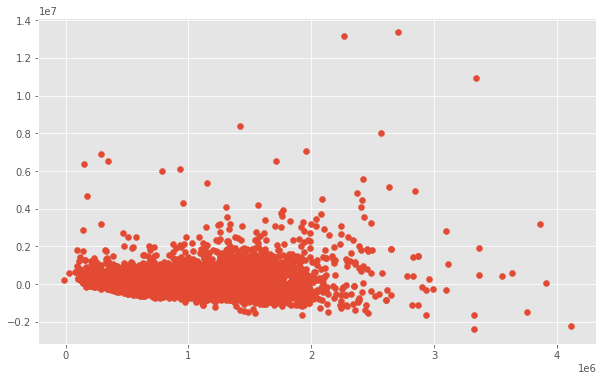

In [8]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);

 - from this picture it apppears that our model is a worse predictor as homes go above 1 million dollars
 
**Let's check normality**

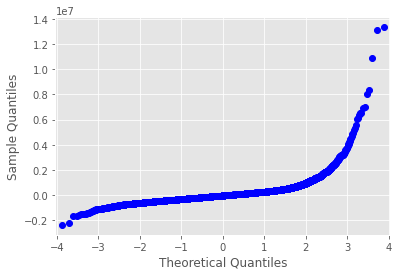

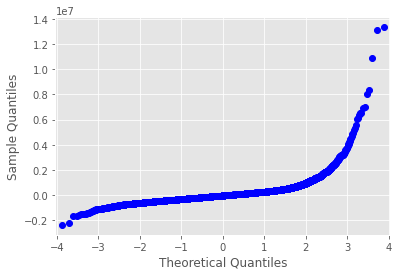

In [9]:
sm.qqplot(fsm_resids)

 - The eyeball test here is to look for a straight line, which it clearly is not!
 - This is supported by the JB p-value in the above summary table, which tells us that this is not normally distributed

### Let's try do drop some outliers 

let's remove elements with a z-score outsize of [-3,3] in either the sale price or the square foot columns

In [10]:
from scipy import stats
ssm_df = fsm_df[(np.abs(stats.zscore(fsm_df)) < 3).all(axis=1)]

In [11]:
formula = 'SalePrice ~ SqFtTotLiving'
ssm = ols(formula=formula, data=ssm_df).fit()

In [12]:
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:50:50   Log-Likelihood:            -2.5776e+05
No. Observations:               18360   AIC:                         5.155e+05
Df Residuals:                   18358   BIC:                         5.155e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.587e+05   5933.069     26.755      0.000    1.47e+05     1.7e+05
SqFtTotLiving   279.5570      2.646    105.664      0.000     274.371     284.743
==============================================================================
Omnibus:                     3717.266   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9797.794
Skew:                           1.097   Prob(JB):                         0.00
Kurtosis:                       5.827   Cond. No.                     5.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### looks like we have a very different coefficient, but no improvement in the R^2

ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

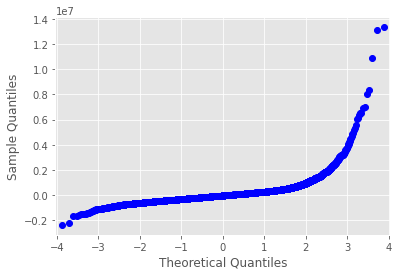

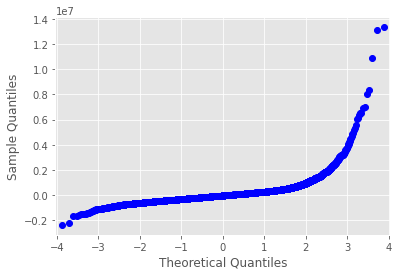

In [13]:
sm.qqplot(fsm_resids)

### Let's look at our footprint column again
we created the footprint column by taking the first floor square footage, and diving by the lot size

In [14]:
foot_df = df[["SalePrice", "footprint"]].copy()
foot_df.dropna(inplace=True)
formula = 'SalePrice ~ footprint'
footmodel = ols(formula=formula, data=foot_df).fit()

In [15]:
footmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.580
Date:                Thu, 18 Jun 2020   Prob (F-statistic):            0.00591
Time:                        10:50:51   Log-Likelihood:            -2.7662e+05
No. Observations:               18807   AIC:                         5.532e+05
Df Residuals:                   18805   BIC:                         5.533e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.771e+05   8382.167     92.707      0.000    7.61e+05    7.94e+05
footprint   1.087e+05   3.95e+04      2.753      0.006    3.13e+04    1.86e+05
==============================================================================
Omnibus:                    22410.386   Durbin-Watson:                   1.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5961811.683
Skew:                           6.062   Prob(JB):                         0.00
Kurtosis:                      89.377   Cond. No.                         9.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We see no correlation between footprint and sale price

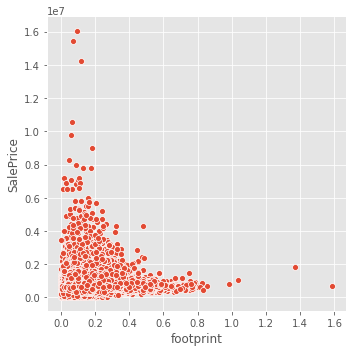

In [16]:
sns.relplot(x='footprint', y='SalePrice', data=foot_df)

### perhaps if we take the logarithm of the sale price

In [17]:
foot_df['log_price'] = np.log(foot_df.SalePrice)

In [18]:
foot_df['inv-footprint'] = np.reciprocal(foot_df.footprint)

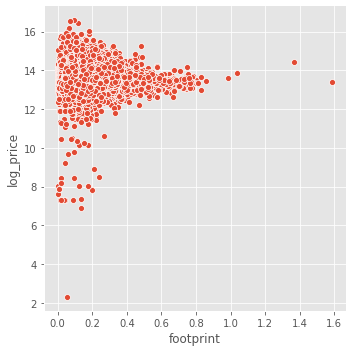

In [19]:
sns.relplot(x='footprint', y='log_price', data=foot_df)

### Curious to check out the relationship between zip code and sale price

In [28]:
zipcode_df = df[['SalePrice', 'SqFtTotLiving', 'ZipCode']].copy()
zipcode_df.dropna(inplace=True)
zipcode_df['ZipCode'] = zipcode_df['ZipCode'].str.slice(0,5)
zipcode_df.ZipCode.unique()

zipcode_df.to_csv('../../data/zipcodes.csv')
#save this for further exploration in the maptime notebook

### We'll try to see if adding a bathroom count to our model can improve it

In [26]:
fsm_df = df[["SalePrice", "SqFtTotLiving", 'SqFtTotBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving  + SqFtTotBasement + SqFtOpenPorch + SqFtEnclosedPorch  '
fsm = ols(formula=formula, data=fsm_df).fit()

In [27]:
fsm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     3110.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:52:57   Log-Likelihood:            -2.7185e+05
No. Observations:               18807   AIC:                         5.437e+05
Df Residuals:                   18802   BIC:                         5.438e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.143e+04   8216.234     -1.391      0.164   -2.75e+04    4677.562
SqFtTotLiving       344.6761      3.923     87.853      0.000     336.986     352.366
SqFtTotBasement      96.8628      6.102     15.875      0.000      84.903     108.822
SqFtOpenPorch       284.8062     24.102     11.817      0.000     237.565     332.048
SqFtEnclosedPorch   164.3542     91.069      1.805      0.071     -14.149     342.858
==============================================================================
Omnibus:                    24081.487   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12571271.145
Skew:                           6.683   Prob(JB):                         0.00
Kurtosis:                     128.952   Cond. No.                     5.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
fsm_df.corr()

,SalePrice,SqFtTotLiving,SqFtTotBasement,SqFtOpenPorch,SqFtEnclosedPorch
SalePrice,1.000000,0.622011,0.270560,0.277837,0.008851
SqFtTotLiving,0.622011,1.000000,0.309810,0.363750,-0.003722
SqFtTotBasement,0.270560,0.309810,1.000000,-0.004396,0.015401
SqFtOpenPorch,0.277837,0.363750,-0.004396,1.000000,-0.009966
SqFtEnclosedPorch,0.008851,-0.003722,0.015401,-0.009966,1.000000


In [29]:
zipcode_df

,SalePrice,SqFtTotLiving,ZipCode
8,358308,2240.0,98002
11,850000,3500.0,98166
22,465000,2360.0,98032
36,350000,1240.0,98168
39,520000,3030.0,98168
...,...,...,...
62023,608220,1570.0,98126
62024,620000,1010.0,98126
62030,510000,1820.0,98055
62035,1275000,3830.0,98166


In [44]:
rich_codes = ['98039', '98004', '98040']
zipcode_df['money_zone'] = zipcode_df.ZipCode.isin(rich_codes)


In [55]:
fsm_df = zipcode_df[["SalePrice", "SqFtTotLiving", 'money_zone']].copy()
fsm_df = fsm_df[(fsm_df.SalePrice >= 200000) & (fsm_df.SalePrice < 9000000)]
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving + money_zone'
fsm = ols(formula=formula, data=fsm_df).fit()

In [56]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     7984.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:17:37   Log-Likelihood:            -2.3115e+05
No. Observations:               16203   AIC:                         4.623e+05
Df Residuals:                   16200   BIC:                         4.623e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8.198e+04   7341.806     11.166      0.000    6.76e+04    9.64e+04
money_zone[T.True]  1.028e+06    1.8e+04     57.086      0.000    9.93e+05    1.06e+06
SqFtTotLiving        318.2059      3.266     97.432      0.000     311.804     324.607
==============================================================================
Omnibus:                    13720.979   Durbin-Watson:                   1.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           898591.365
Skew:                           3.697   Prob(JB):                         0.00
Kurtosis:                      38.726   Cond. No.                     1.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""